In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/imbalanceddata/Imbalanced_data.png


# 1- Introduction
At Santander their mission is to help people and businesses prosper. They are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

In this kernel we are going to creater a Machine Learning Explainability for Santander based this perfect course in kaggle.

# 2- Load packages
## 2-1 Import


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import glob
import sys
import os
import gc

## 2-2 Setup

In [3]:
# for get better result change fold_n to 5\
fold_n = 5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option('display.precision', 15)

# 3- Problem Definition
We should help this bank identify which suctomers will make a specific transaction in the future, irrspective of the amount fo money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem

## 3-3 Variables
We are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column.
The task is to predict the value of target column in the test set.

## 3-4 Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve

# 4- EDA
In this section, we'll analysis how to use graphical and numerical techniques to begin uncovering the structure of your data.
- Data collection
- Visualization
- Data Preprocessing
- Data Cleaning

# 4-2 Data collection


In [5]:
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

In [6]:
sample_submission = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv')
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [7]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [8]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.093000000000000,11.460699999999999,-9.2834,5.1187,18.626600000000000,...,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.388999999999999,12.362200000000000,7.0433,5.6208,16.533799999999999,...,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.355999999999998,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.892800000000000,10.582500000000000,-9.0837,6.9427,14.615500000000001,...,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,train_3,0,11.060400000000000,-2.1518,8.952199999999999,7.195700000000000,12.584600000000000,-1.8361,5.8428,14.925000000000001,...,4.4666,4.7433,0.7178,1.421400000000000,23.034700000000001,-1.2706,-2.9275,10.292199999999999,17.969700000000000,-8.999599999999999
4,train_4,0,9.836900000000000,-1.4834,12.874599999999999,6.637500000000000,12.277200000000001,2.4486,5.9405,19.251400000000000,...,-1.4905,9.5214,-0.1508,9.194200000000000,13.287599999999999,-1.5121,3.9267,9.503100000000000,17.997399999999999,-8.810400000000000


## Reducing memory size by ~50%

In [9]:
# Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [10]:
# Reducing for train data set

train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276611328125  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

In [11]:
# Reducing for test data set

test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017822265625  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

## 4-2 Data set fields

In [12]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [13]:
print(len(train.columns))

202


In [14]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
None


### 4-2-2 numerical values Describe

In [15]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,...,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789,2.640832424163818,2.043276309967041,1.623113632202148,7.863115310668945,0.866584956645966,3.418008565902710,3.332575798034668,...,4.559854030609131,3.023208379745483,1.478387713432312,3.991934061050415,3.135113477706909,1.429340600967407,5.454273700714111,0.921603024005890,3.010892391204834,10.437831878662109
min,0.000000000000000,0.408399999141693,-15.043399810791016,2.117100000381470,-0.040199998766184,5.074800014495850,-32.562599182128906,2.347300052642822,5.349699974060059,-10.505499839782715,...,-14.093299865722656,-2.691699981689453,-3.814500093460083,-11.783399581909180,8.694399833679199,-5.261000156402588,-14.209600448608398,5.960599899291992,6.299300193786621,-38.852798461914062
25%,0.000000000000000,8.453850269317627,-4.740024805068970,8.722474813461304,5.254074931144714,9.883174657821655,-11.200350046157837,4.767700195312500,13.943799972534180,-2.317800045013428,...,-0.058825000189245,5.157400131225586,0.889775007963181,0.584599971771240,15.629799842834473,-1.170699954032898,-1.946925014257431,8.252799987792969,13.829700469970703,-11.208474636077881
50%,0.000000000000000,10.524750232696533,-1.608050048351288,10.579999923706055,6.824999809265137,11.108250141143799,-4.833149909973145,5.385099887847900,16.456800460815430,0.393700003623962,...,3.203599929809570,7.347749948501587,1.901299953460693,3.396350026130676,17.957949638366699,-0.172700002789497,2.408900022506714,8.888199806213379,15.934050083160400,-2.819550037384033
75%,0.000000000000000,12.758199691772461,1.358625024557114,12.516699790954590,8.324099540710449,12.261124849319458,0.924799978733063,6.002999782562256,19.102899551391602,2.937900066375732,...,6.406199932098389,9.512524843215942,2.949500083923340,6.205800056457520,20.396524906158447,0.829599976539612,6.556725144386292,9.593299865722656,18.064724445343018,4.836800098419189
max,1.000000000000000,20.315000534057617,10.376799583435059,19.353000640869141,13.188300132751465,16.671400070190430,17.251600265502930,8.447699546813965,27.691799163818359,10.151300430297852,...,18.440900802612305,16.716499328613281,8.402400016784668,18.281799316406250,27.928800582885742,4.272900104522705,18.321500778198242,12.000399589538574,26.079099655151367,28.500699996948242


## 4-2 Visualization

### 4-2-2 hist

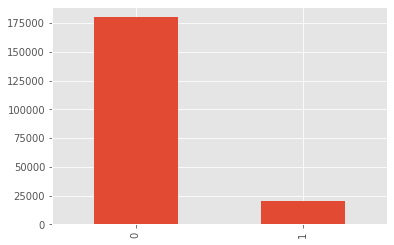

In [16]:
train['target'].value_counts().plot.bar()   # target 데이터 파악

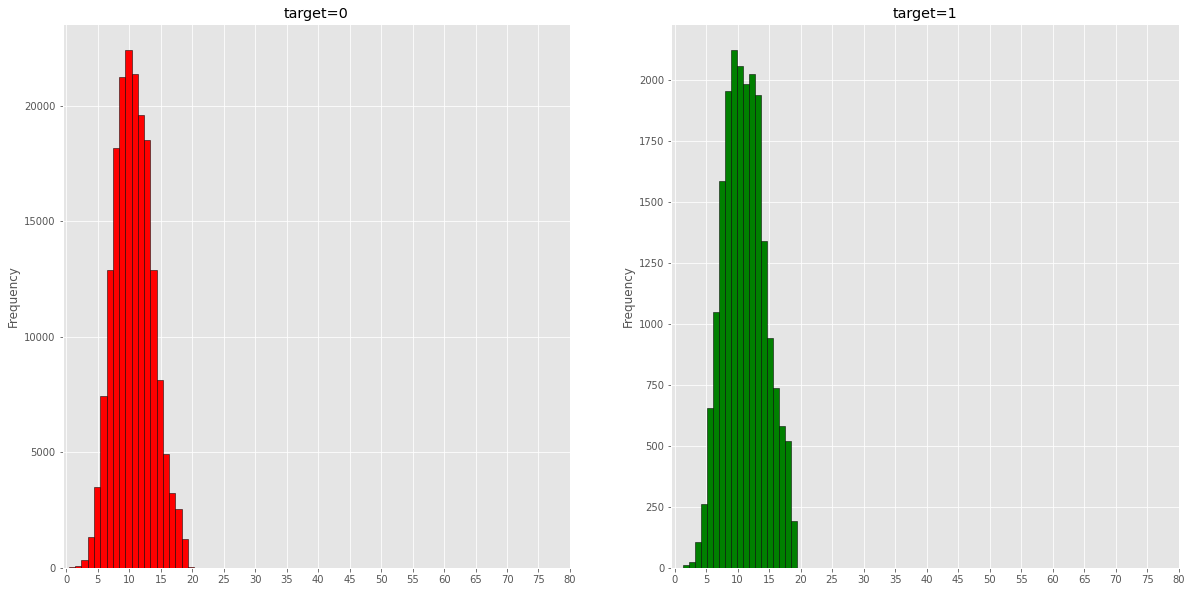

In [17]:
f, ax = plt.subplots(1,2,figsize=(20,10))
x_range=list(range(0,85,5))

train[train['target']==0].var_0.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('target=0')
ax[0].set_xticks(x_range)

train[train['target']==1].var_0.plot.hist(ax=ax[1], color='green', bins=20, edgecolor='black')
ax[1].set_title('target=1')
ax[1].set_xticks(x_range)
plt.show()

# var_0의 target 0/1의 Frequency

### 4-2-2 Mean Frequency

Text(0.5, 1.0, 'Mean Frequency')

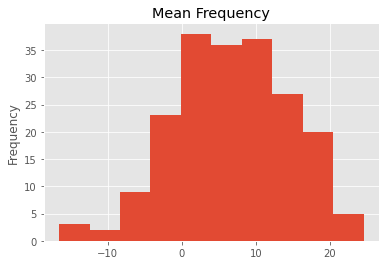

In [18]:
train[train.columns[2:]].mean().plot('hist')
plt.title('Mean Frequency')

### 4-2-3 Countplot

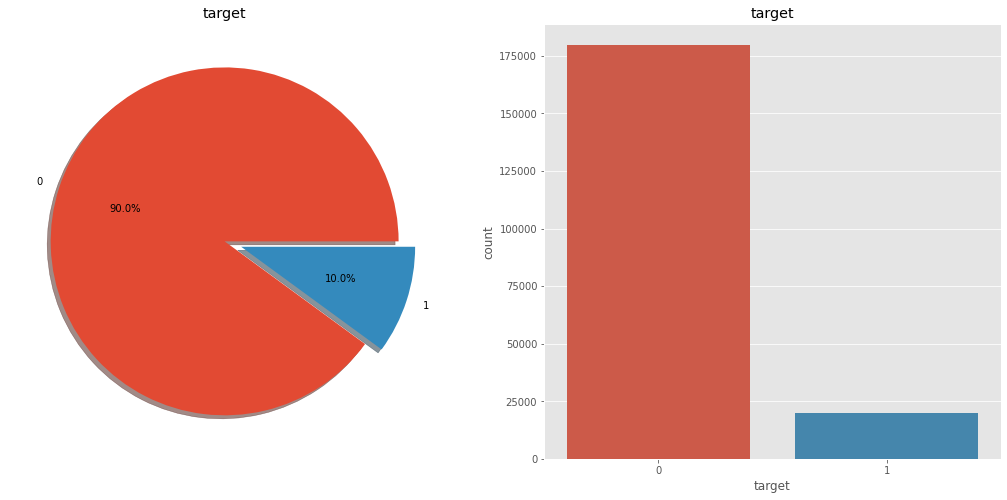

In [19]:
f, ax = plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')

sns.countplot('target', data=train, ax=ax[1])
ax[1].set_title('target')

plt.show()

### 4-2-4 hist

If you check histogram for all feature, you will find that most of them are so similar

In [20]:

def hist(df):
    i=0
    plt.figure()
    fig, ax = plt.subplots(20,11, figsize=(25,35))
    features = train.columns.to_list()[1:]
    
    for feature in features:
        i += 1
        plt.subplot(20,11,i)
        train[feature].hist()
        plt.xlabel(feature, fontsize=5)
    plt.show()

<Figure size 432x288 with 0 Axes>

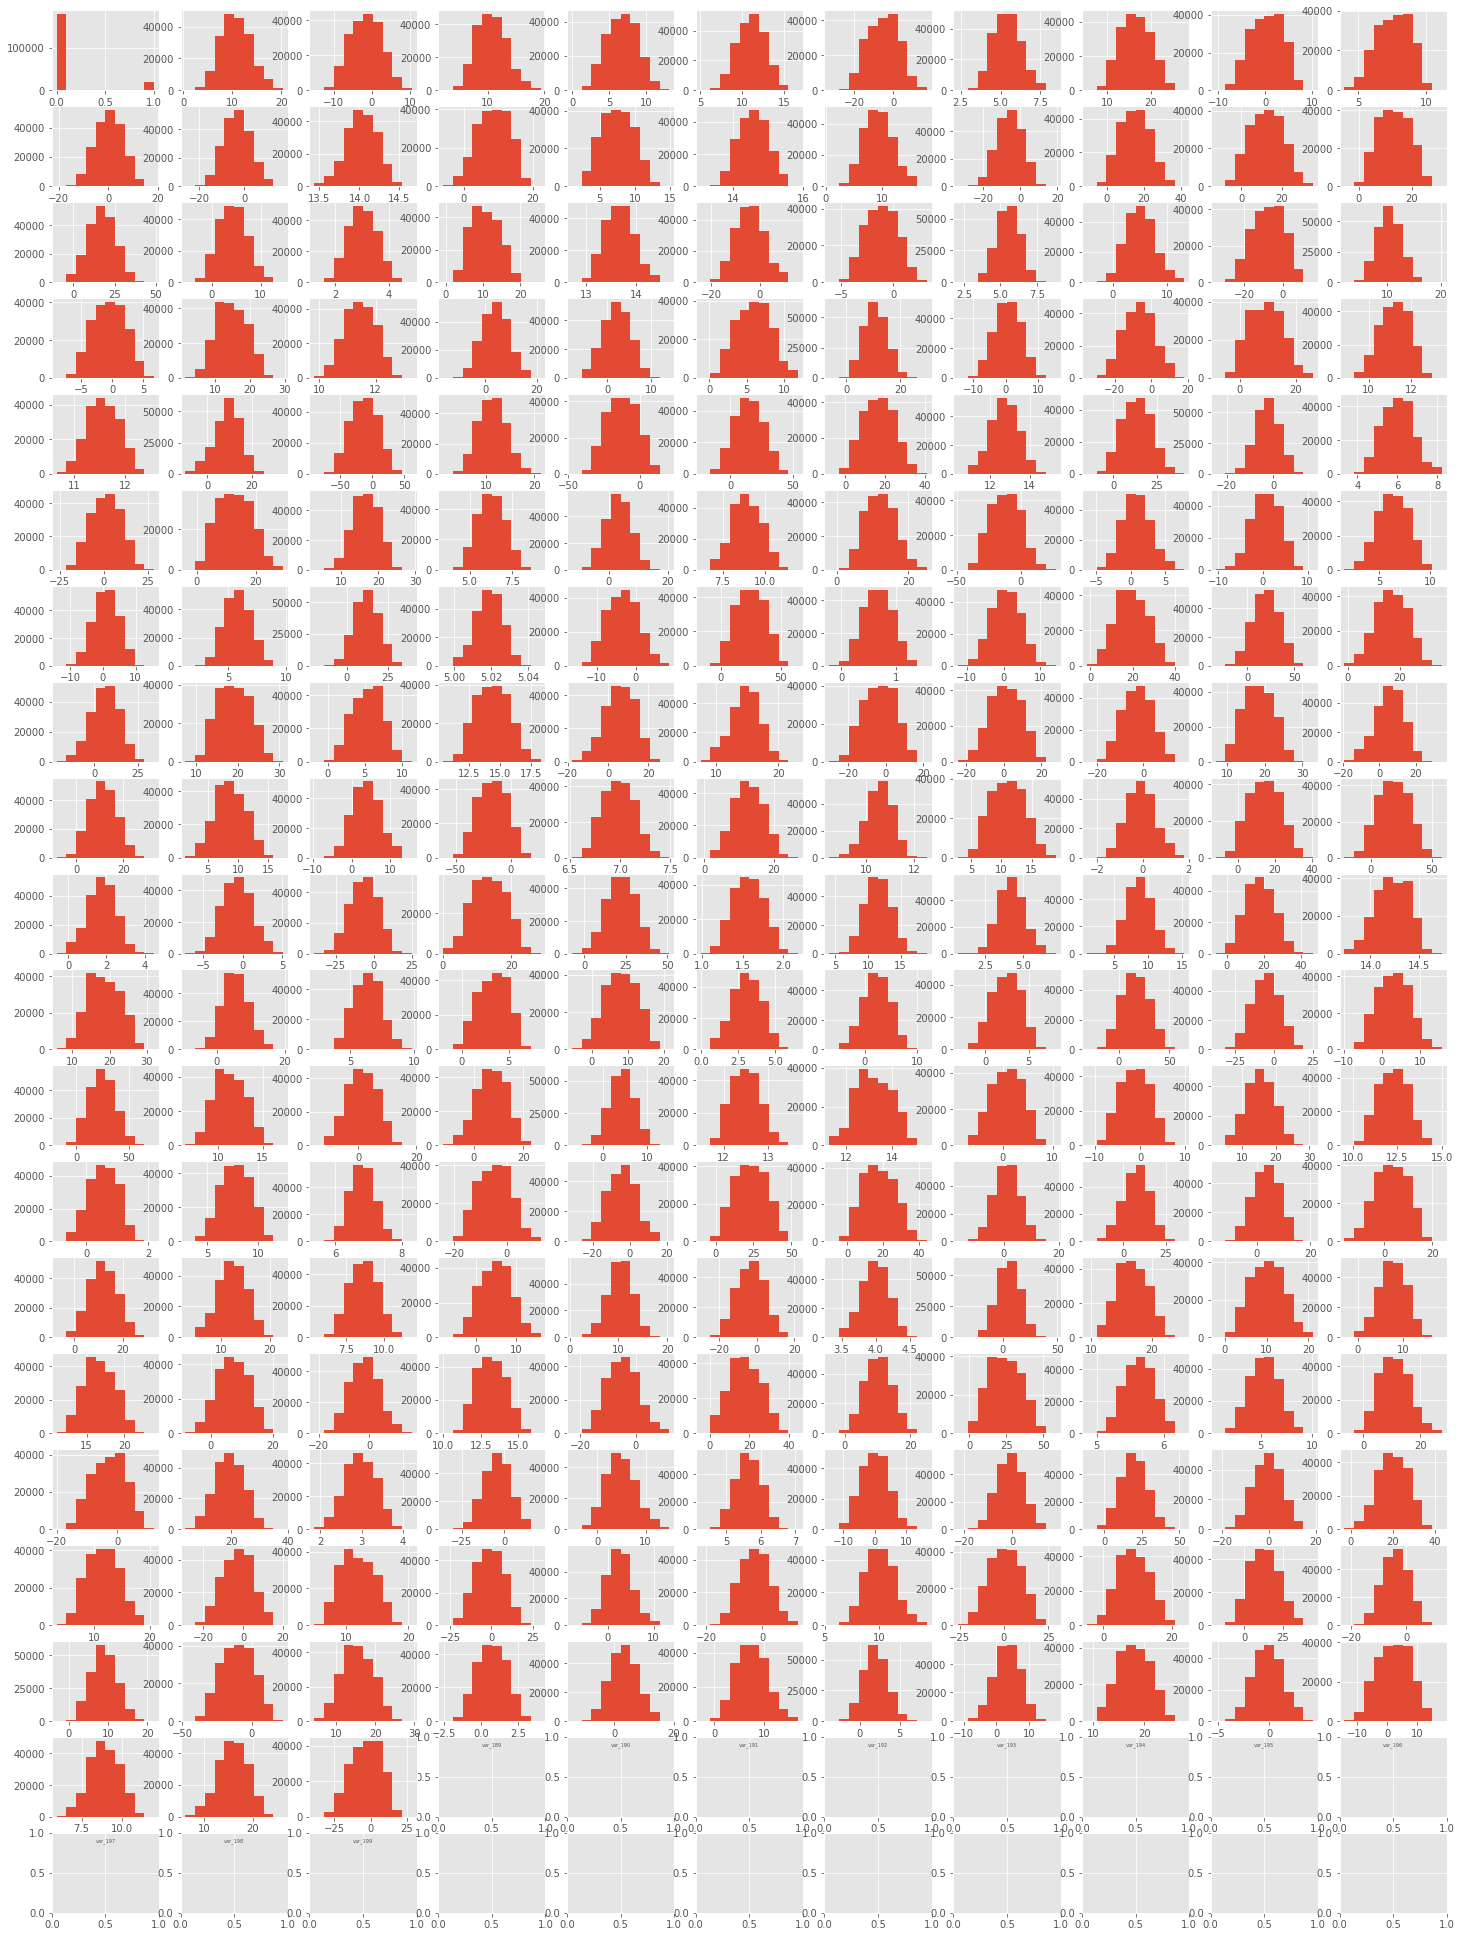

In [21]:
hist(train)

### 4-2-7 violinplot

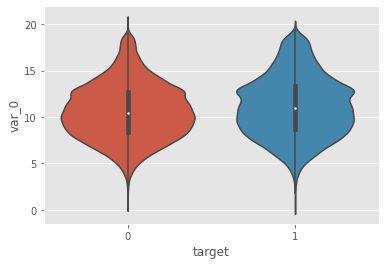

In [22]:
sns.violinplot(datat=train, x=train['target'], y=train['var_0'])

### Check missing data for test & train

In [23]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent=(df.isnull().sum()) / (df.isnull().count() * 100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        
        data_type=[]
        for col in df.columns:
            dtype=str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [24]:
check_missing_data(train)

False

In [25]:
check_missing_data(test)

False

### 4-3-2 Binary Classification

In [26]:
train['target'].unique()

# target 값이 Binary인지 확인

array([0, 1], dtype=uint64)

### 4-3-3 Is data set imbalance?
A Large part of the data is unbalanced, but how can we solve it?

In [27]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [28]:
def check_balance(df, target):
    check=[]
    print('size of data is :', df.shape[0])
    for i in [0,1]:
        print('for target {} ='.format(i))
        print(df[target].value_counts()[i] / df.shape[0] * 100, '%')

1. Imbalanced dataset is relevant primarily in the context of supervised machine learning involving two or more classes.
2. Imbalance means that the number of data points available for different the classes is different.

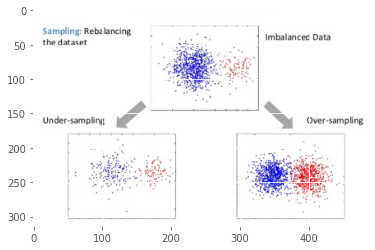

In [29]:
import PIL.Image as pilimg

image = pilimg.open('/kaggle/input/imbalanceddata/Imbalanced_data.png')
image.show()
pix = np.array(image)

plt.imshow(pix)

In [30]:
check_balance(train, 'target')

size of data is : 200000
for target 0 =
89.95100000000001 %
for target 1 =
10.049 %


### 4-3-4 skewness and kurtosis

In [31]:
print('Skewness: %f' % train['target'].skew())
print('Kurtosis: %f' % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


# 5- Machine Learning Explainability for Santander
In this section, I want to try extract insights from models.

The Goal behind of ML Expainability for Santander is:
1. All features are senseless named.(var_1, var_2...) but certainly the importance of each one is different.
2. Extract insights from models
3. Find the most important feature in models.
4. Affect of each feature on the model's predictions


- Permutation Importance
- Partial Plots
- SHAP Valeues

As you can see from the above, we will refer to three important and practical concepts in this section and try to explain each of them in detail.

## 5-1 Permutation Importance
In this section we will answer following question:
    1. What feature have the biggest impact on predictions?
    2. How to extract insights from model?

In [32]:
cols = ['target','ID_code']
X = train.drop(cols, axis=1)  # variables 로만 이루어진 dataset X
y = train['target']   # target column

X_test = test.drop('ID_code', axis=1)

#### Create a sample model to calculate which feature are more important.

In [33]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

rfc = RandomForestClassifier(random_state=0).fit(train_X, train_y)

## 5-2 How to calculate and show importances?  ; eli5 library

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc, random_state=1).fit(val_X, val_y)

eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)



원래 결과는 var_110, 157, 162, 42 순으로 나열됨

## 5-3 What can be inferred from the above?
1. As you move down the top of the graph, the importance of the feature decreases.
2. The features that are shown in green indicate that they have a positive impact on our prediction
3. White -> no effect
4. Red -> negative impact
5. The most important feature was Var_110.

In [34]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [35]:
features = [c for c in train.columns if c not in ['ID_code','target']]

In [36]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

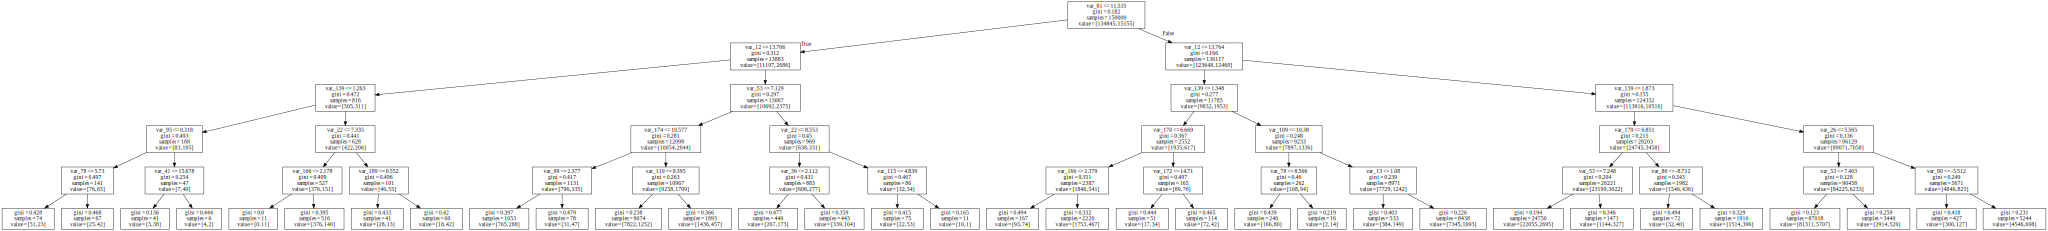

In [37]:
graphviz.Source(tree_graph)

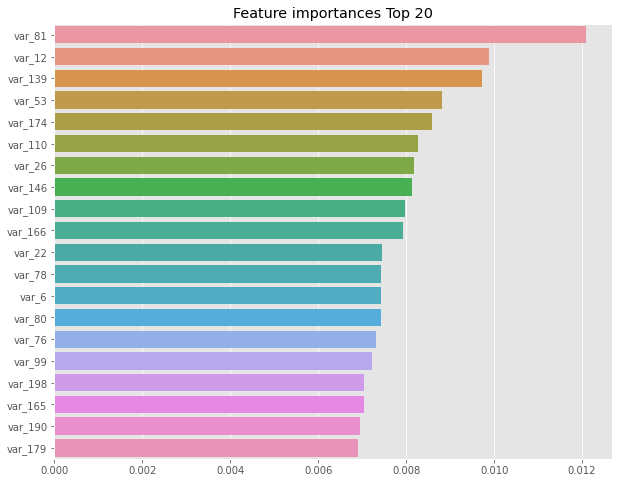

In [38]:
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=train_X.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10,8))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

As guidance to read the tree:
1. Leaves with children show their splitting creterion on the top
2. The pair of values at the bottom show the count of True values and False values for the target respectively, of data points in that node of the tree.

> Note: Var_81 are more effective on our model

The decision tree has itx own rules to select one feature to split their nodes, like imformation gain or Gini impurity, for example. So their judging methods are different. Thus their important features are different.

## 5-5 Partial Dependence Plots
In this section, we see the impact of the main variables discovered in the previous sections by using the pdpbox.

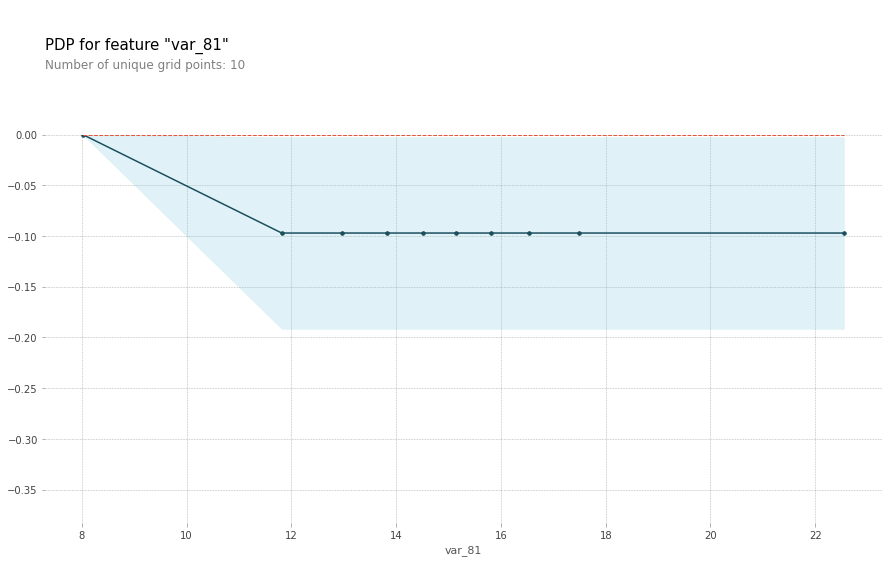

In [39]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

## 5-6 Chart analysis
1. The 'y' axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
2. A blue shaded area indicates level of confidence

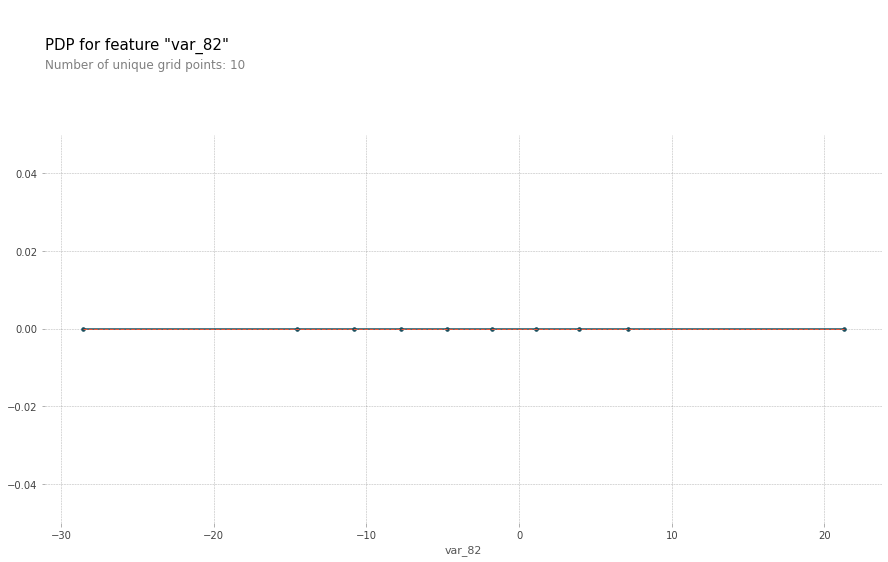

In [40]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_82')

# plot it
pdp.pdp_plot(pdp_goals, 'var_82')
plt.show()

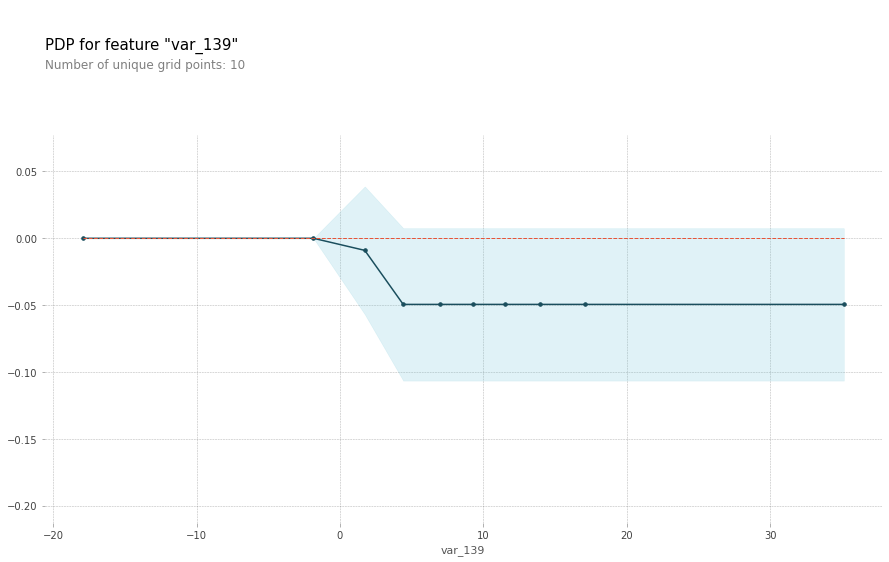

In [41]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

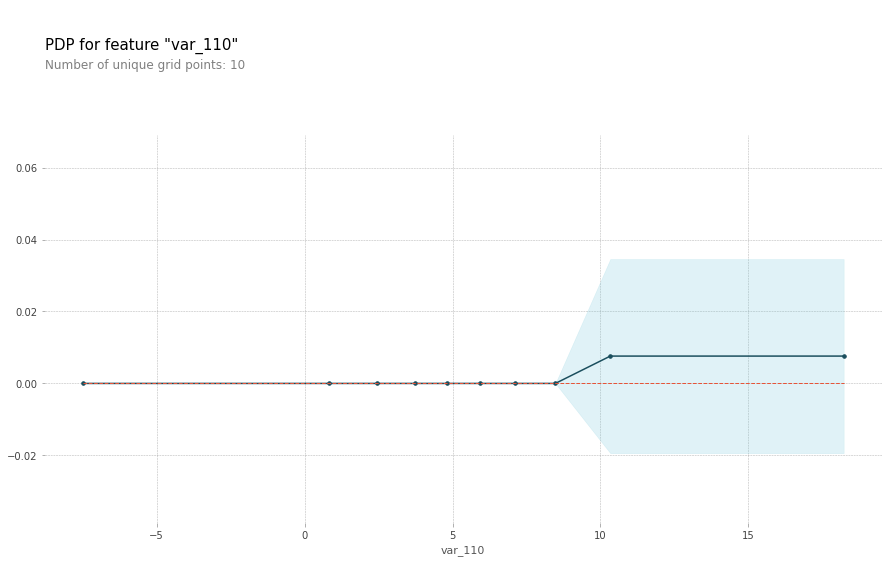

In [42]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

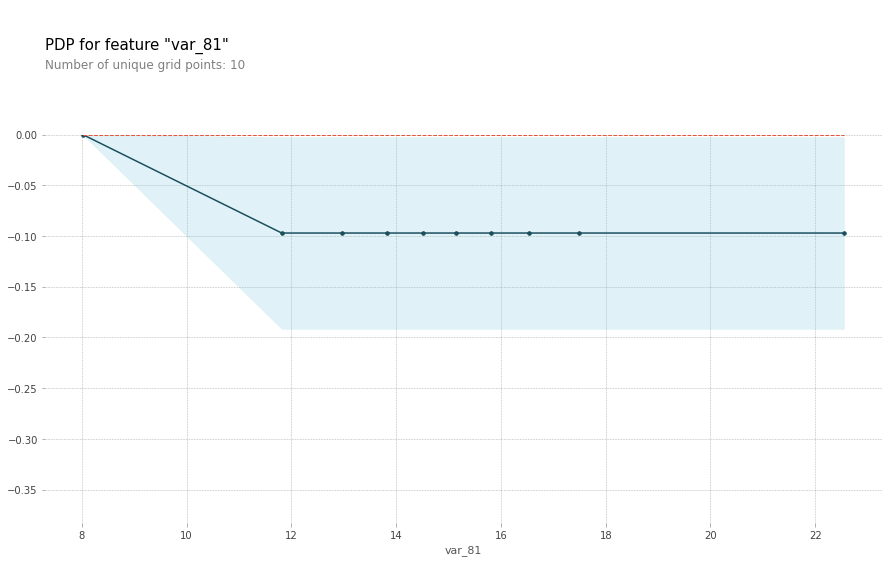

In [43]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

## 5-7 SHAP Values
SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory whth local explanations, uniting several previous methods[1-7] and representing the only possible consistent and locally accyrate additive feature attribution method based on expectations.

> Note : Shap can answer to this question: how the model works for an individual prediction?

In [44]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # 5행만 보여줌. 여러 행에 대해서도 적용 가능함
data_for_prediction_array = data_for_prediction.values.reshape(1,-1)

rfc.predict_proba(data_for_prediction_array)

array([[0.88, 0.12]])

In [45]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

IndexError: invalid index to scalar variable.

In [46]:
data_for_prediction

var_0       6.602200031280518
var_1      -4.600100040435791
var_2      11.753499984741211
var_3       9.961600303649902
var_4      12.487799644470215
                  ...        
var_195    -1.436300039291382
var_196    -0.305099993944168
var_197     8.576899528503418
var_198    13.591400146484375
var_199   -14.086199760437012
Name: 167783, Length: 200, dtype: float32

In [47]:
y_pred_rfc = rfc.predict(X_test)

In [48]:
submission_rfc = pd.DataFrame({'ID_cod':test['ID_code'],
                              'target': y_pred_rfc})
submission_rfc.to_csv('submission_rfc.csv', index=False)

https://www.kaggle.com/mjbahmani/santander-ml-explainability
    